In [61]:
# imports
from keras.datasets import mnist
from matplotlib import pyplot as plt
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.metrics

# **3. Load the mnist dataset**
***

In [58]:
# define random seed
random.seed(42)

# **4. Present simple statistics of this dataset:**
***

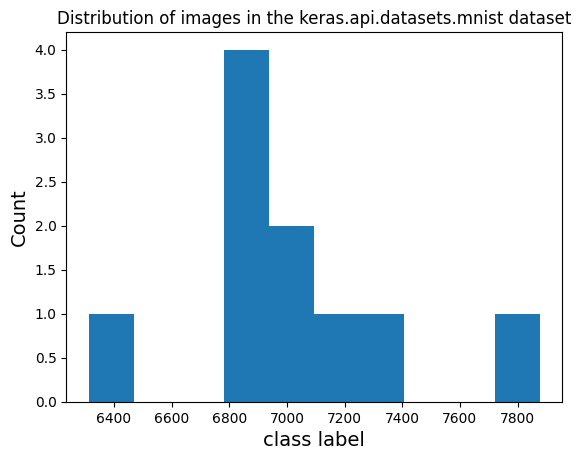

,Number of images,Class distribution,Average number of white pixels,Standard deviation of white pixels,Common non-white pixels per class
0,70000,6903,7.240910,24.266312,345
1,70000,7877,3.613685,10.816985,490
2,70000,6990,5.944492,20.322924,300
3,70000,7141,5.953368,20.555728,326
4,70000,6824,4.847743,16.463461,316
5,70000,6313,5.359575,18.257221,310
6,70000,6876,5.504945,18.786060,356
7,70000,7293,4.539284,15.439864,332
8,70000,6825,5.555458,19.388457,350
9,70000,6958,4.716010,15.829870,359


In [54]:
def show_statistics(dataset):
    """
    Shows some statistics about the dataset
    :param dataset: 
    :return: 
    """
    # load the dataset
    (input_train, labels_train),(input_test,labels_test) = dataset.load_data()
     
     # combine training and test
    images = np.concatenate((input_train, input_test), axis=0)
    labels = np.concatenate((labels_train, labels_test), axis=0)
    
    # number of images
    num_images = len(images)
    
    # show the distribution of the images
    class_distribution = np.bincount(labels)
    plt.title(f'Distribution of images in the {dataset.__name__} dataset')
    plt.xlabel('class label', fontsize=14)

    plt.ylabel('Count', fontsize=14)
    plt.hist(class_distribution)
    plt.show()
    
    # average number of white pixels(255) and their std per class
    average_white_pixels = []
    std_white_pixels = []
    common_non_white_pixels = []
    
    for digit in range(10): # 10 digits 0-9:
        digit_images = images[labels == digit]
        white_pixels_count = np.sum(digit_images == 255, axis=(1, 2)) # columns of pixels, with consideration to RGB matrix
        average_white_pixels.append(np.mean(white_pixels_count))
        std_white_pixels.append(np.std(white_pixels_count))
        
        #calculate common non-white pixels
        common_non_white = np.all(digit_images!= 255, axis =0).sum()    # if any pixel is not 255, he is not white sum all the areas of that along the images
        common_non_white_pixels.append(common_non_white)
    # Compile results
    statistics = {
        "Number of images": num_images,
        "Class distribution": class_distribution,
        "Average number of white pixels": average_white_pixels,
        "Standard deviation of white pixels": std_white_pixels,
        "Common non-white pixels per class": common_non_white_pixels
    }
    
    df_statistics = pd.DataFrame(statistics)
    
    display(df_statistics)     
show_statistics(mnist) 


    

# **5.Apply a simple neural network**
***


In [66]:
# Load and prepare the MNIST dataset

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize pixel values to a range of 0 to 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Build a simple neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),  # Flatten the 28x28 images to a 1D array
    tf.keras.layers.Dense(128, activation='relu'),  # Fully connected layer with 128 units and ReLU activation
    tf.keras.layers.Dropout(0.2),  # Dropout layer to prevent overfitting
    tf.keras.layers.Dense(10)  # Output layer with 10 units (one for each digit class)
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['recall','accuracy','Precision',"f1_score" ])

# Train the model
model.fit(x_train, y_train, epochs=5)

# Evaluate the model on test data
model.evaluate(x_test, y_test, verbose=2)
pass

KeyboardInterrupt: 